
# Time Series Forecasting using Auto Arima

In [1]:
%matplotlib inline

# ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# data manipulation
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, date

# data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy

# set font scale and style
plt.rcParams.update({'font.size': 18})

# stat models
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [2]:
# import custom class
%run -i '../src/helper/ts.py'

In [3]:
# instantiate the class
fxn = TimeSeriesForecasting()

# Load  data

In [4]:
ts = pd.read_csv('../data/collision_ts_month.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (228, 16)


,fatality_rate,med_fatal,med_injury,med_no_injury,conf_ind_head-on,conf_ind_not-head-on,c_hour,fri_fatality_rate,mon_fatality_rate,sat_fatality_rate,sun_fatality_rate,thurs_fatality_rate,tues_fatality_rate,weds_fatality_rate,year,month
date,,,,,,,,,,,,,,,,
1999-01-01,0.012911,163.0,164.0,89.0,152.0,281.0,13.511338,0.013243,0.016598,0.014843,0.011677,0.011015,0.008221,0.013807,1999,1
1999-02-01,0.018163,196.0,176.0,97.0,139.0,343.0,13.499924,0.014509,0.014981,0.022738,0.031998,0.018028,0.010420,0.015851,1999,2
1999-03-01,0.020982,219.0,250.0,122.0,149.0,469.0,13.507759,0.013768,0.017110,0.021551,0.027427,0.035515,0.022345,0.013197,1999,3
1999-04-01,0.015418,190.0,154.0,83.0,82.0,356.0,13.890340,0.011209,0.012318,0.019888,0.020989,0.013578,0.016097,0.016417,1999,4
1999-05-01,0.017953,266.0,248.0,99.0,114.0,523.0,13.851641,0.016170,0.021113,0.022777,0.025800,0.011568,0.016212,0.007870,1999,5


## Power Transformation needed?

To check if a power transformation (such as the Box-Cox transformation) of the target variable is necessary, we check if  $\text{max}(y_t)/\text{min}(y_t) >3$. If not, a power transformation might not provide much help.

In [5]:
np.max(ts['fatality_rate'])/np.min(ts['fatality_rate'])

2.652609129707151

##  Create a test  set
We must split the dataset into training and test (out-of-sample) set. 

In [6]:
y = ts['fatality_rate'] # actuals
N = len(y) # data size

cols_to_drop = ['fatality_rate']
exog_variables = list(ts.drop(cols_to_drop, axis=1).columns)
x_exog = ts[exog_variables]

# add seasonality variables
# x_exog['yearly_seasonality'] = np.arange(N) % 365
x_exog['monthly_seasonality'] = np.arange(N) % 30.5
# x_exog['weekly_seasonality'] = np.arange(N) % 7

In [21]:
train_start, train_end = '1999-01-01','2014-12-01'
test_start, test_end = '2014-12-01', '2017-12-01'

x_train = x_exog[train_start: train_end]
y_train = y[train_start: train_end]

x_test = x_exog[test_start: test_end]
y_test = y[test_start: test_end]

## Standardization

In [22]:
# standardization
pscaler = StandardScaler()
scaler = StandardScaler()

y_train_scaled = pscaler.fit_transform(y_train.values.reshape(-1,1)) 
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# pandas dataframe
x_train_df = pd.DataFrame(x_train_scaled, columns = x_train.columns)
x_test_df = pd.DataFrame(x_test_scaled, columns = x_test.columns)

## SARIMAX
We build Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors (SARIMAX) model using pmdarima‘s auto_arima(). We set seasonal = True, the frequency m = 12 for monthly time series, and seasonal differencing D = 1.

In [23]:
# train sarimax from auto arima API
sarimax = pm.auto_arima(y_train_scaled, exogenous=x_train_df, max_p=2, max_q=2, D=1, m=12, 
                        test='adf', stepwise=True, suppress_warnings=True, 
                        error_action='ignore', seasonal=True, random_state=42, 
                        trace=True, n_fits=20
                       )
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=4.45 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-170.142, Time=0.18 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-187.824, Time=5.76 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-222.001, Time=5.00 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-172.142, Time=0.67 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-179.035, Time=1.32 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-224.570, Time=3.43 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-190.898, Time=3.02 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=-227.351, Time=7.27 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-198.474, Time=7.60 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=-223.978, Time=6.78 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=7.32 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=-221.426, Time=5.87 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=-226.069, Time=7.49 sec
 ARIMA(0,0,2)(2,1,1)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  192
Model:             SARIMAX(1, 0, 2)x(2, 1, [1], 12)   Log Likelihood                 138.749
Date:                              Mon, 25 Apr 2022   AIC                           -229.498
Time:                                      18:08:21   BIC                           -152.867
Sample:                                           0   HQIC                          -198.427
                                              - 192                                         
Covariance Type:                                opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept               -0.0146      0.007     -2.046      0.041      -0.029      -0.001
med_fatal               -0.1070      0.074     -1.447      0.148      -0.252       0.038
med_injury              -0.1229      0.066     -1.852      0.064      -0.253       0.007
med_no_injury           -0.0355      0.034     -1.049      0.294      -0.102       0.031
conf_ind_head-on         0.1105      0.052      2.107      0.035       0.008       0.213
conf_ind_not-head-on     0.3224      0.139      2.319      0.020       0.050       0.595
c_hour                   0.0018      0.019      0.091      0.928      -0.036       0.040
fri_fatality_rate        0.3602      0.011     32.276      0.000       0.338       0.382
mon_fatality_rate        0.2296      0.010     23.590      0.000       0.211       0.249
sat_fatality_rate        0.2561      0.012     22.258      0.000       0.234       0.279
sun_fatality_rate        0.2745      0.009     30.962      0.000       0.257       0.292
thurs_fatality_rate      0.2465      0.011     22.255      0.000       0.225       0.268
tues_fatality_rate       0.2493      0.010     24.385      0.000       0.229       0.269
weds_fatality_rate       0.2205      0.010     21.516      0.000       0.200       0.241
year                     0.0628      0.002     26.254      0.000       0.058       0.068
month                 1.527e-08   2.02e-08      0.755      0.450   -2.44e-08    5.49e-08
monthly_seasonality      0.0103      0.006      1.789      0.074      -0.001       0.021
ar.L1                   -0.5703      0.218     -2.616      0.009      -0.998      -0.143
ma.L1                    0.3573      0.227      1.572      0.116      -0.088       0.803
ma.L2                   -0.3637      0.095     -3.828      0.000      -0.550      -0.177
ar.S.L12                 0.1720      0.149      1.152      0.249      -0.121       0.465
ar.S.L24                -0.1542      0.107     -1.444      0.149      -0.363       0.055
ma.S.L12                -0.8444      0.189     -4.464      0.000      -1.215      -0.474
sigma2                   0.0116      0.002      6.381      0.000       0.008       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 2.19
Prob(Q):                              0.50   Prob(JB):                         0.34
Heteroskedasticity (H):               0.69   Skew:                             0.24
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.11e+19. Standard errors may be unst

# Training set (in-sample) prediction

In [24]:
y_train_pred = pscaler.inverse_transform(y_train_scaled - sarimax.resid().values.reshape(-1,1)).flatten()

In [25]:
print("Training set performance errors")
print(30*"-")
fxn.error_metrics(y_train, y_train_pred)

Training set performance errors
------------------------------


{'MAE = 0.0', 'MAPE = 1.337', 'RMSE = 0.0', 'R^2 = 0.985', 'WMAPE = 1.322'}

## Model Diagnostics Plot on the Training Set

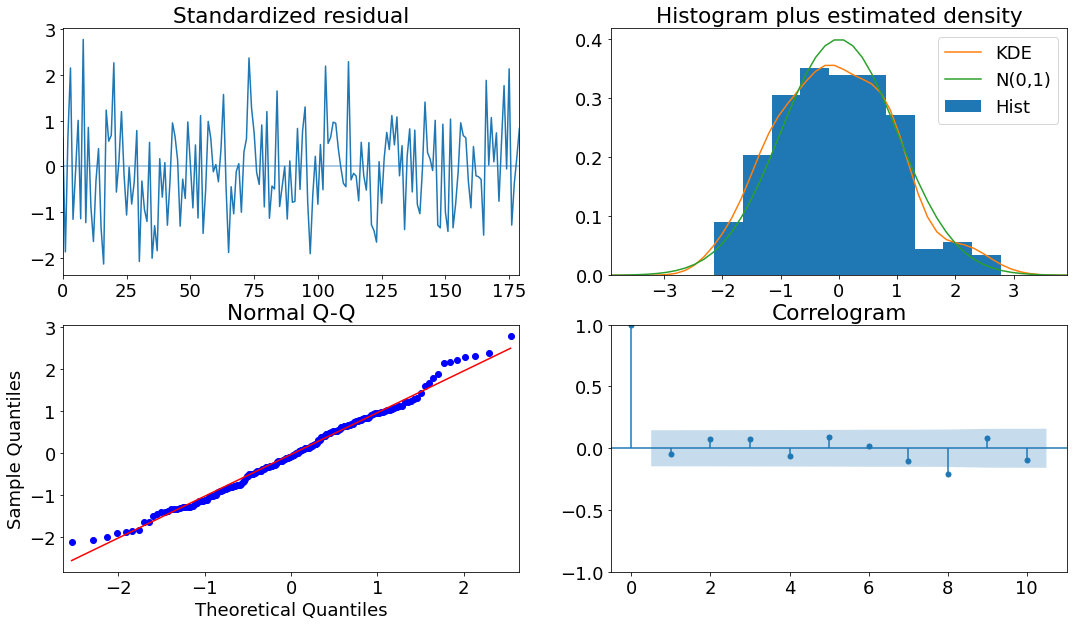

In [26]:
sarimax.plot_diagnostics(figsize=(18,10))
plt.show()

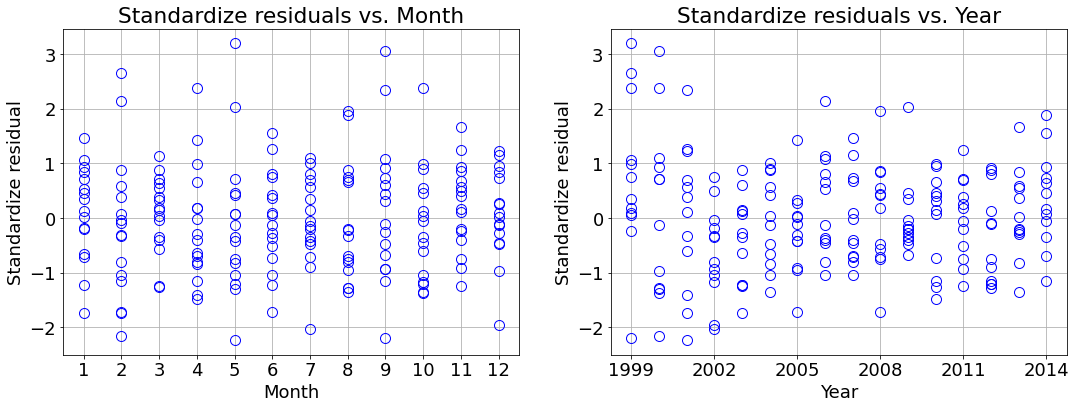

In [27]:
# training set standardize residual
tresid = y_train-y_train_pred
tstandard = (tresid-np.mean(tresid))/np.std(tresid)

plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(tstandard.index.month, tstandard, color = 'b', marker = 'o', markerfacecolor = 'none',
         linestyle = '', markersize=10)
plt.grid(True)
plt.xlabel('Month')
plt.ylabel('Standardize residual')
plt.xticks(np.arange(1,13,1))
plt.title('Standardize residuals vs. Month')

plt.subplot(122)
plt.plot(tstandard.index.year, tstandard, color = 'b', marker = 'o', markerfacecolor = 'none',
         linestyle = '', markersize=10)
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Standardize residual')
plt.xticks(np.arange(1999,2015,3))
plt.title('Standardize residuals vs. Year')
plt.show()

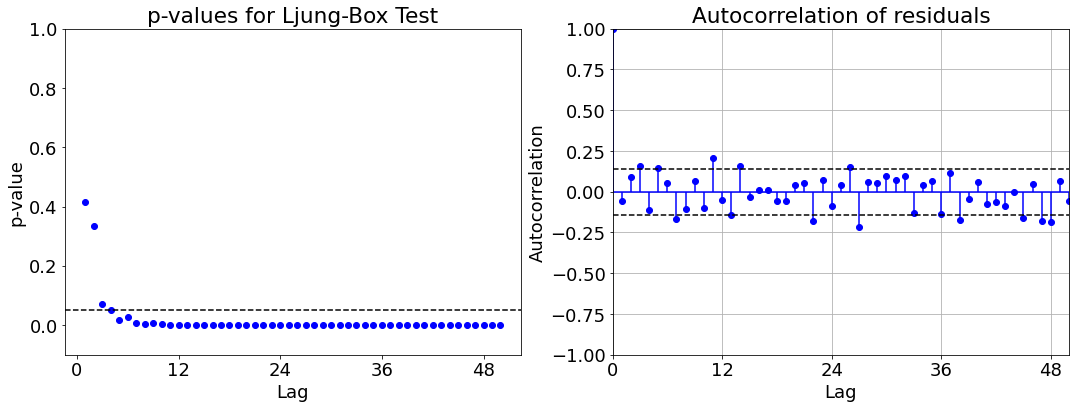

In [28]:
plt.figure(figsize = (18,6))
plt.subplot(121)
lb = acorr_ljungbox(tresid, lags = 50)[1]
plt.plot(np.arange(1,len(lb)+1), lb, 'o', color = 'b')
plt.axhline(y=0.05,linestyle= '--', color = 'k')
plt.ylabel('p-value')
plt.xlabel('Lag')
plt.xticks(np.arange(0,len(lb),12))
plt.ylim(-0.1,1)
plt.title('p-values for Ljung-Box Test')

plt.subplot(122)
plt.acorr(tresid, usevlines=True, maxlags=50, normed=True, color ='b')
plt.acorr(tresid, usevlines=False, maxlags=50, normed=True,color ='b')
plt.axhline(y=1.96/np.sqrt(len(tresid)),linestyle= '--', linewidth=1.5, color = 'k')
plt.axhline(y=-1.96/np.sqrt(len(tresid)),linestyle= '--', linewidth=1.5, color = 'k')
plt.xlim(0,50)
plt.ylim(-1,1)
plt.xticks(np.arange(0,50,12))
plt.grid(True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of residuals')
plt.show()

# Test set (out-of-sample) prediction

In [29]:
y_pred, conf_int = sarimax.predict(n_periods=len(y_test), exogenous=x_test_df, return_conf_int=True)
y_pred = pscaler.inverse_transform(y_pred.reshape(-1,1)).flatten() # inverse transform scale

print("Test set performance errors")
print(30*"-")
fxn.error_metrics(y_test, y_pred)

Test set performance errors
------------------------------


{'MAE = 0.0', 'MAPE = 1.357', 'RMSE = 0.0', 'R^2 = 0.99', 'WMAPE = 1.354'}

In [30]:
y_pred[y_pred<0] = 0

y_low = conf_int[:,0]
y_low = pscaler.inverse_transform(y_low.reshape(-1,1)).flatten()
y_high = conf_int[:,1]
y_high = pscaler.inverse_transform(y_high.reshape(-1,1)).flatten()

results = pd.DataFrame()
results['y_pred'] = y_pred
results['y_low'] = y_low
results['y_high'] = y_high
results.index = y_test.index

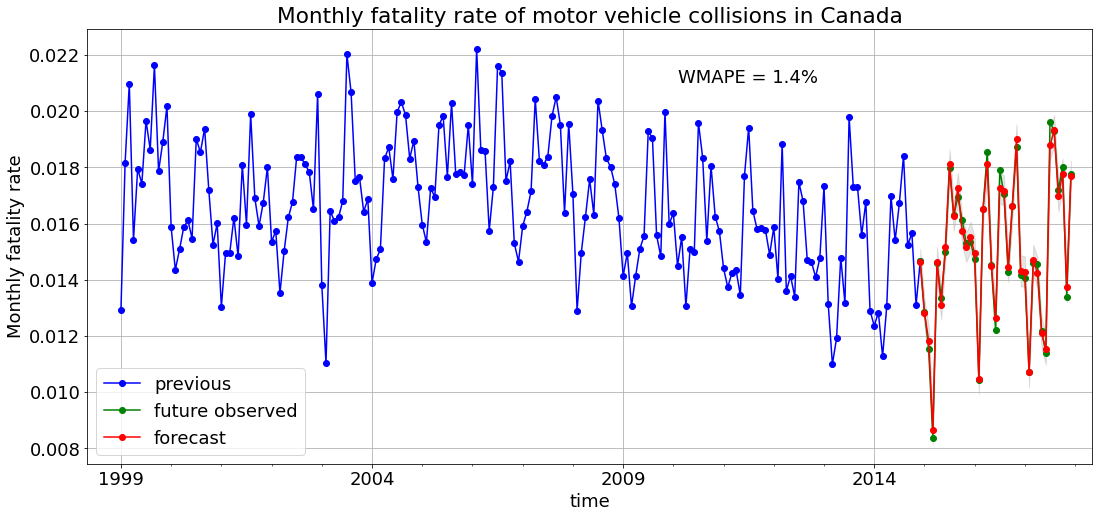

In [36]:
plt.figure(figsize = (18,8))

# y_train.iloc[-len(y_test):].plot(label = 'previous', color = 'b')
y_train.plot(label = 'previous',  marker = 'o', color = 'b')
y_test.plot(label = 'future observed', marker = 'o', color = 'g')
results['y_pred'].plot(label = 'forecast', marker = 'o', color = 'r')

plt.fill_between(results.index, results['y_low'], results['y_high'], color='k', alpha=0.1)
plt.xlabel('time')
plt.text('2010-02-01', 0.021, "WMAPE = 1.4%")
plt.grid(True)
plt.ylabel('Monthly fatality rate')
plt.title('Monthly fatality rate of motor vehicle collisions in Canada')
plt.xlim('1998-05-01', '2018-05-01')
plt.legend(loc = 'best')
plt.savefig('../images/figfcst.png')
plt.show()

## Model Diagnostics Plot on the Test Set

## 1. Standadized residual of the test set 

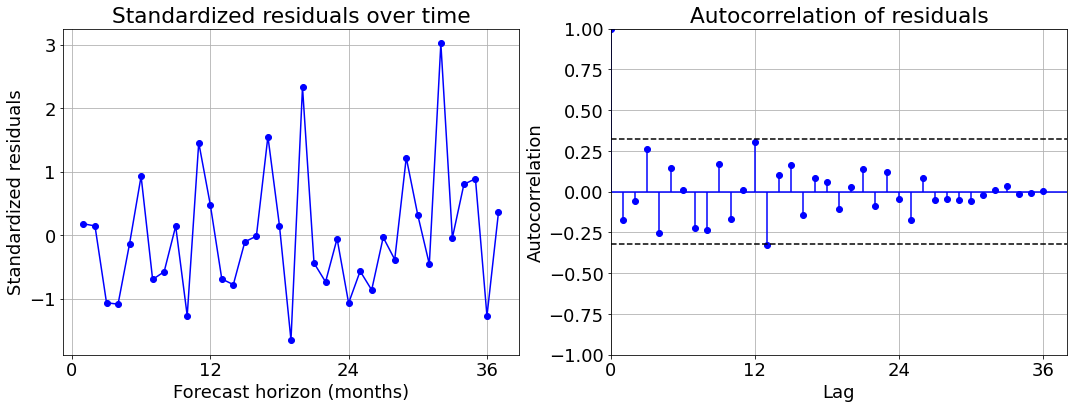

In [33]:
plt.figure(figsize = (18,6))
residual = y_test-results['y_pred']
rstandard = (residual-np.mean(residual))/np.std(residual)

plt.subplot(121)
plt.plot(range(1,len(rstandard)+1), rstandard, color = 'b', marker = 'o')
plt.grid(True)
plt.xlabel('Forecast horizon (months)')
plt.ylabel('Standardized residuals')
plt.xticks(np.arange(0,len(rstandard)+1,12))
plt.title('Standardized residuals over time')

plt.subplot(122)
plt.acorr(residual, usevlines=True, maxlags=len(residual)-1, normed=True, color ='b')
plt.acorr(residual, usevlines=False, maxlags=len(residual)-1, normed=True,color ='b')
plt.axhline(y=1.96/np.sqrt(len(residual)),linestyle= '--', linewidth=1.5, color = 'k')
plt.axhline(y=-1.96/np.sqrt(len(residual)),linestyle= '--', linewidth=1.5, color = 'k')
plt.xlim(0,len(residual)+1)
plt.ylim(-1,1)
plt.xticks(np.arange(0,len(residual)+1,12))
plt.grid(True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of residuals')
plt.savefig('../images/figdplot1.png')
plt.show()

# pd.plotting.autocorrelation_plot(pd.Series(residual), color = 'b', marker = 'o')
# plt.title('Autocorrelation of residuals')
# plt.xlim(0,50)
# plt.xticks(np.arange(0,len(residual)+1,12))
# plt.show()

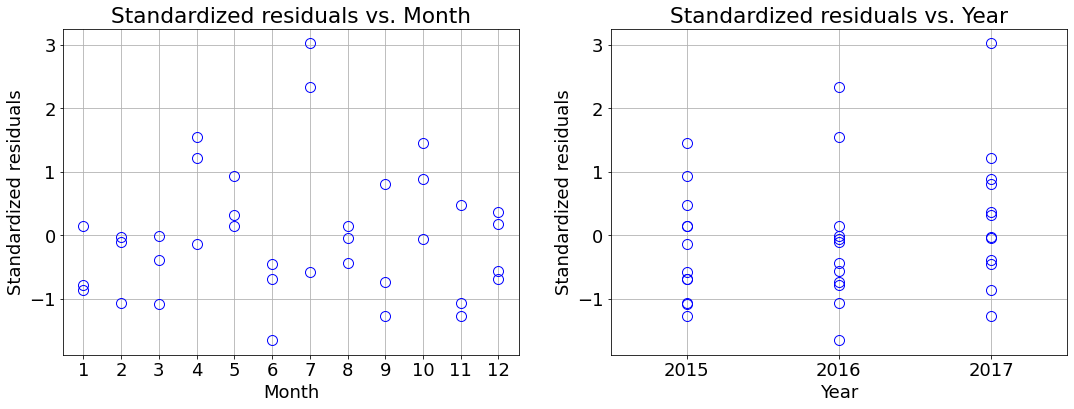

In [34]:
plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(rstandard.index.month, rstandard, color = 'b', marker = 'o', markerfacecolor = 'none',
         linestyle = '', markersize=10)
plt.grid(True)
plt.xlabel('Month')
plt.ylabel('Standardized residuals')
plt.xticks(np.arange(1,13,1))
plt.title('Standardized residuals vs. Month')

plt.subplot(122)
plt.plot(rstandard.index.year, rstandard, color = 'b', marker = 'o', markerfacecolor = 'none',
         linestyle = '', markersize=10)
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Standardized residuals')
plt.xticks(np.arange(2015,2018))
plt.xlim(2014.5,2017.5)
plt.title('Standardized residuals vs. Year')
plt.savefig('../images/figdplot2.png')
plt.show()

## 2. Ljung-Box test

A good forecasting model will have zero correlation between its residuals. Correlation in residuals means that some information were left out which should have been used in forecasting.

We use the Ljung-Box test to check if the residuals (absolute percent error) from the time series model resemble white noise (i.e., zero autocorrelation). The null hypothesis states that the residuals are independently and identically distributed, that is the errors are uncorrelated. Therefore, a p-value greater than 0.05 means that we do not have enough information (or statistically significant evidence) to reject the null hypothesis. However, this does not mean that the forecasting model cannot be improved.

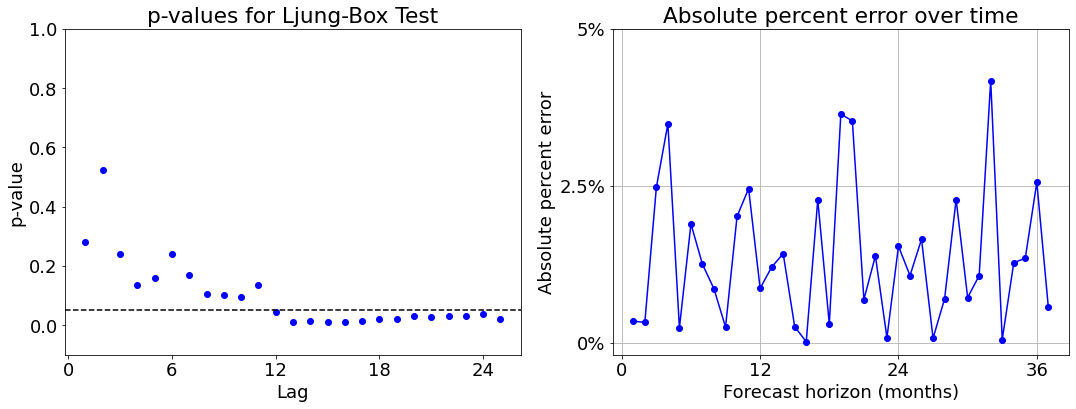

In [35]:
ape = np.abs(residual)*100/np.abs(y_test)

plt.figure(figsize = (18,6))
plt.subplot(121)
lb = acorr_ljungbox(residual, lags = 25)[1]
plt.plot(np.arange(1,len(lb)+1), lb, 'o', color = 'b')
plt.axhline(y=0.05,linestyle= '--', color = 'k')
plt.ylabel('p-value')
plt.xlabel('Lag')
plt.xticks(np.arange(0,len(lb),6))
plt.ylim(-0.1,1)
plt.title('p-values for Ljung-Box Test')

plt.subplot(122)
plt.plot(range(1,len(ape)+1), ape, color = 'b', marker = 'o')
plt.grid(True)
plt.xlabel('Forecast horizon (months)')
plt.ylabel('Absolute percent error')
plt.title('Absolute percent error over time')
label = ['0%', '2.5%', '5%']
plt.xticks(np.arange(0,len(ape)+1,12))
plt.yticks(np.arange(0,6,2.5),label)
plt.savefig('../images/figlb.png')
plt.show()